In [1]:
import argparse
import os

from pathlib import Path

import torch
from torch.backends import cudnn

from tqdm import tqdm

from utils.checkpoint import save_checkpoint
from datasets.vessel_set import VesselSet, AneuriskVesselSet
from modules.edm import EDMLoss, EDMPrecond
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import vtk
import numpy as np
from vtk.util import numpy_support  # Ensure this is imported


# Read the .vtp file
reader = vtk.vtkXMLPolyDataReader()
reader.SetFileName("centerlines/0001-network.vtp")
reader.Update()

# Get the polydata object from the reader
polydata = reader.GetOutput()

# Get the points from the polydata
points_vtk_array = polydata.GetPoints().GetData()

if polydata.GetPoints() is not None:
    # Get the points from the polydata
    points_vtk_array = polydata.GetPoints().GetData()

    # Convert VTK array to a NumPy array with shape (NumberOfPoints, 3)
    points = numpy_support.vtk_to_numpy(points_vtk_array)

    print("Extracted points coordinates:", np.array(points).shape)
else:
    print("No points found in the file.")



# Initialize an array to store line IDs for each point
line_ids = np.full(points.shape[0], -1)  # Default to -1 for points without a line assignment

# Assign line IDs to points based on cells (lines)
for line_id in range(polydata.GetNumberOfCells()):
    cell = polydata.GetCell(line_id)  # Each cell is a line with multiple points
    point_ids = cell.GetPointIds()  # Get the point IDs for the current line

    # Assign the current line_id to each point in this line
    for i in range(point_ids.GetNumberOfIds()):
        line_ids[point_ids.GetId(i)] = line_id

# Combine points and line IDs into a single array
points_with_line_ids = np.hstack((points, line_ids.reshape(-1, 1)))

print("Points with line IDs (x, y, z, line_id):")
print(points_with_line_ids)

Extracted points coordinates: (122, 3)
Points with line IDs (x, y, z, line_id):
[[35.7594223  59.80244827 39.67420197  0.        ]
 [35.32811356 58.07311249 40.09186935  0.        ]
 [34.79156113 56.9550209  41.36901855  0.        ]
 [34.68395615 56.3708992  42.30879593  0.        ]
 [35.05499649 55.48483658 43.91479111  0.        ]
 [35.69831085 55.06909943 45.1795578   0.        ]
 [36.41843033 54.86870193 46.18415833  0.        ]
 [37.46755981 54.69267654 47.10786438  0.        ]
 [38.49105453 54.5633812  47.74536133  0.        ]
 [41.77066422 54.42916489 48.98639679  0.        ]
 [43.58059311 54.30939484 49.39413071  0.        ]
 [45.4037056  53.96253586 49.98297882  0.        ]
 [46.64204407 53.48760605 50.24514389  0.        ]
 [48.00107574 52.46397781 50.35545349  0.        ]
 [49.35310364 50.3851738  50.05570602  0.        ]
 [74.02971649 54.54873276 43.89385986  1.        ]
 [73.92865753 53.67111206 44.84450531  1.        ]
 [74.0870285  52.99388504 45.68091965  1.        ]
 [

In [3]:
from extras import serial2centerline
from vtk.util.numpy_support import vtk_to_numpy


    
def vtk_np(filename):
    '''
    reader = vtk.vtkXMLPolyDataReader()
    reader.SetFileName(filename)
    reader.Update()

    # Get the polydata object from the reader
    polydata = reader.GetOutput()'''

    # Get the points from the polydata
    
    polydata = serial2centerline(filename)
   
    points_vtk_array = polydata.GetPoints().GetData()

   
    # Get the points from the polydata
    points_vtk_array = polydata.GetPoints().GetData()

    # Convert VTK array to a NumPy array with shape (NumberOfPoints, 3)
    points = numpy_support.vtk_to_numpy(points_vtk_array)

    #print("Extracted points coordinates:", np.array(points).shape)
    

    # Initialize an array to store line IDs for each point
    line_ids = np.full(points.shape[0], -1)  # Default to -1 for points without a line assignment
    print(polydata.GetNumberOfCells())
    # Assign line IDs to points based on cells (lines)
    for line_id in range(polydata.GetNumberOfCells()):
        cell = polydata.GetCell(line_id)  # Each cell is a line with multiple points
        point_ids = cell.GetPointIds()  # Get the point IDs for the current line
        # Assign the current line_id to each point in this line
        for i in range(point_ids.GetNumberOfIds()):
            line_ids[point_ids.GetId(i)] = line_id

    # Combine points and line IDs into a single array
    

    #print("Points with line IDs (x, y, z, line_id):")
    #print(points_with_line_ids)
    idnum = filename.split("-")[0].split("/")[1]
    point_data = polydata.GetPointData()

    # Extract the "Radius" array (this is the array name as you mentioned)
    radius_array = point_data.GetArray("Radius")

    # Convert the VTK array to a NumPy array
    radius = vtk_to_numpy(radius_array)

    points_with_line_ids = np.hstack((points, line_ids.reshape(-1, 1)))
    points_with_line_ids = np.hstack((points, radius.reshape(-1, 1), line_ids.reshape(-1, 1)))

    return points_with_line_ids

def vtk_np(filename):
    '''
    reader = vtk.vtkXMLPolyDataReader()
    reader.SetFileName(filename)
    reader.Update()

    # Get the polydata object from the reader
    polydata = reader.GetOutput()'''

    # Get the polydata object from your custom serial2centerline function
    polydata = serial2centerline(filename)

    # Get the points and radius data
    points_vtk_array = polydata.GetPoints().GetData()
    points = numpy_support.vtk_to_numpy(points_vtk_array)
    point_data = polydata.GetPointData()
    radius_array = point_data.GetArray("Radius")
    radius = numpy_support.vtk_to_numpy(radius_array)

    # Initialize a list to store points with line IDs
    points_with_line_ids = []

    # Iterate through each line (cell) in the polydata
    for line_id in range(polydata.GetNumberOfCells()):
        cell = polydata.GetCell(line_id)  # Each cell is a line
        point_ids = cell.GetPointIds()  # Get point IDs for the current line

        # Collect each point's data for this line
        for i in range(point_ids.GetNumberOfIds()):
            point_index = point_ids.GetId(i)
            point_coords = points[point_index]  # Get x, y, z coordinates
            point_radius = radius[point_index]  # Get radius
            points_with_line_ids.append([*point_coords, point_radius, line_id])

    # Convert to a numpy array
    points_with_line_ids = np.array(points_with_line_ids)

    return points_with_line_ids
#l_corte tiene las bifurcaciones y hojas
#l_corte2 tiene los hijos de las bifurcaciones
#d2 tiene a los hijos de las bifurcaciones maapeados al id de la bifurcaion
centerline = vtk_np("p10/0002_tree.dat")
print(centerline[:,:])


l_corte [9, 0, 18, 14, 22, 21, 23]
l_corte2 [1, 10, 15, 19, 22, 23]
d2 {1: 0, 10: 0, 15: 14, 19: 14, 22: 21, 23: 21}
d {0: [None, <modelovae.Node object at 0x7f938e07a5f0>, <modelovae.Node object at 0x7f938ab3d150>], 14: [<modelovae.Node object at 0x7f938ab3d1e0>, <modelovae.Node object at 0x7f938ab3d240>, <modelovae.Node object at 0x7f938ab3d300>], 21: [<modelovae.Node object at 0x7f938ab3d330>, <modelovae.Node object at 0x7f938ab3d390>, <modelovae.Node object at 0x7f938ab3d3c0>]}
d_id {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23}
Lines and their point IDs: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [0, 10, 11, 12, 13, 14], [14, 15, 16, 17, 18], [14, 19, 20, 21], [21, 22], [21, 23]]
[[0.58196193 0.42788485 0.33225089 0.03429911 0.        ]
 [0.59117085 0.40720084 0.37443441 0.03639136 0.        ]
 [0.6166932  0.40227884 0.40468279 0.03654943 0.        ]
 [0.64071256 0.4

creo que lo que falta es agregar a la linea el padre de la bifurcacion

In [4]:
all_vessels = []
max_segments = 4  # Only keep the first four segments

files = os.listdir("p10")
print(files)
for file in files:
    
    aneu = vtk_np(os.path.join("p10", file))
    print(aneu.shape)
    segment_numbers = np.unique(aneu[:, -1]).astype(int)  # Segment numbers (branch numbers) as integers
    print(segment_numbers)
    # Collect segments for this vessel
    segments = []
    for seg_num in segment_numbers:
        if seg_num >= max_segments:
            #print(f"Warning: Segment number {seg_num} exceeds max_segments ({max_segments - 1}). Skipping this segment.")
            continue  # Skip this segment if it exceeds the max_segments

        # Filter rows for the current segment and remove the segment number column
        segment_points = aneu[aneu[:, -1] == seg_num][:, :-1]

            
        segments.append(segment_points)
    print(segments)
    # Keep only the first four segments (or all segments if fewer than 4)
    segments = segments[:max_segments]
        

    # Find the maximum number of points in any segment for this vessel
    max_points = max(segment.shape[0] for segment in segments)

    # If fewer than 4 segments are available, pad with zeros
    while len(segments) < max_segments:
        segments.append(np.zeros((max_points, 4)))  # Assuming each segment has the same number of features

    # Pad each segment to have the same number of points
    padded_segments = [
        np.pad(segment, ((0, max_points - segment.shape[0]), (0, 0)), 'constant')
        for segment in segments
    ]
        
        
    # Stack all segments for this vessel along a new dimension (axis 0)
    vessel_data = np.stack([padded_segments], axis=0)

    # Add the stacked segments for this vessel to the list of all vessels
    all_vessels.append(vessel_data)

# Determine the maximum points across all vessels

max_points = max(arr.shape[2] for arr in all_vessels)
# Pad each array to have the shape (max_segments, max_points, 16)
padded_arrays = []
for arr in all_vessels:
    # Calculate padding for the points dimension
    pad_points = max_points - arr.shape[2]
    # Pad the array
    padded_arr = np.pad(
        arr,
        pad_width=((0, 0), (0, 0), (0, pad_points), (0, 0)),
        mode='constant',
        constant_values=0  # Padding value can be adjusted if necessary
    )
    padded_arrays.append(padded_arr)
    


# Stack the padded arrays along a new dimension
final_data = np.stack(padded_arrays, axis=0)
print(final_data.shape)
#final_data = final_data.reshape(102,4,-1,4)
final_data = final_data.squeeze(1)
print("Final data shape:", final_data.shape)  # Expected shape: (num_vessels, max_segments, max_points, 16)

train = final_data[:90,:,:,:]
test =  final_data[90:,:,:,:]
np.save("datasets/aneurisk/data_train.npy", train)
np.save("datasets/aneurisk/data_test.npy", test)

['0069_tree.dat', '0074b_tree.dat', '0080_tree.dat', '0077_tree.dat', '0055_tree.dat', '0027_tree.dat', '0016_tree.dat', '0090_tree.dat', '0015_tree.dat', '0038_tree.dat', '0067_tree.dat', '0059_tree.dat', '0096_tree.dat', '0083_tree.dat', '0025_tree.dat', '0053_tree.dat', '0030_tree.dat', '0002_tree.dat', '0051_tree.dat', '0042_tree.dat', '0022_tree.dat', '0001_tree.dat', '0032_tree.dat', '0008_tree.dat', '0039_tree.dat', '0087_tree.dat', '0043_tree.dat', '0097_tree.dat', '0044_tree.dat', '0086_tree.dat', '0029_tree.dat', '0073_tree.dat', '0040_tree.dat', '099_tree.dat', '0035_tree.dat', '0028a_tree.dat', '0063_tree.dat', '0033_tree.dat', '0088a_tree.dat', '0082_tree.dat', '0050_tree.dat', '0006_tree.dat', '0054_tree.dat', '0045_tree.dat', '0011_tree.dat', '0064_tree.dat', '0068_tree.dat', '0007_tree.dat', '0021_tree.dat', '0010_tree.dat', '0013_tree.dat', '0048_tree.dat', '0018_tree.dat', '0062_tree.dat', '0065_tree.dat', '0061_tree.dat', '0034_tree.dat', '0057a_tree.dat', '0014_tree

(30, 5)
[-1, 9, 18]

(20, 5)
[0 1 2 3]


In [5]:
final_data[0].shape

(4, 10, 4)

In [6]:
final_data[0][0]

array([[0.26451916, 0.39731291, 0.15917486, 0.02036213],
       [0.2845619 , 0.37590906, 0.15776807, 0.02194079],
       [0.29825288, 0.35972422, 0.16714461, 0.02205201],
       [0.30623394, 0.3459163 , 0.18144329, 0.02174644],
       [0.31016031, 0.33473927, 0.19985959, 0.02198672],
       [0.31049711, 0.32832754, 0.22167151, 0.02252305],
       [0.30821145, 0.32759419, 0.24111503, 0.02263012],
       [0.27811021, 0.33929911, 0.31310794, 0.02455316],
       [0.24948715, 0.34449813, 0.37941676, 0.02504275],
       [0.22633408, 0.34409294, 0.42767754, 0.02576798]])

In [7]:
tree = final_data[0]
valid_segments = []
for segment in tree:
    # Remove rows with all zeros (padded points)
    valid_points = segment[np.any(segment != 0, axis=-1)]
    if valid_points.shape[0] > 1:  # Include segment only if it has valid points
        valid_segments.append(valid_points)

valid_segments

[array([[0.26451916, 0.39731291, 0.15917486, 0.02036213],
        [0.2845619 , 0.37590906, 0.15776807, 0.02194079],
        [0.29825288, 0.35972422, 0.16714461, 0.02205201],
        [0.30623394, 0.3459163 , 0.18144329, 0.02174644],
        [0.31016031, 0.33473927, 0.19985959, 0.02198672],
        [0.31049711, 0.32832754, 0.22167151, 0.02252305],
        [0.30821145, 0.32759419, 0.24111503, 0.02263012],
        [0.27811021, 0.33929911, 0.31310794, 0.02455316],
        [0.24948715, 0.34449813, 0.37941676, 0.02504275],
        [0.22633408, 0.34409294, 0.42767754, 0.02576798]]),
 array([[0.26451916, 0.39731291, 0.15917486, 0.02036213],
        [0.22942437, 0.42923462, 0.16887665, 0.01979531],
        [0.19081129, 0.46073979, 0.19442084, 0.02168495],
        [0.16825463, 0.47044158, 0.22348627, 0.02477639],
        [0.16667095, 0.50104213, 0.2489792 , 0.02281241],
        [0.17154747, 0.52383852, 0.2937957 , 0.02055155],
        [0.19180423, 0.54040563, 0.32583156, 0.01985649],
        [0.2

In [8]:
points_per_segment = [len(segment) for segment in valid_segments]
total_points = sum(points_per_segment)
print(points_per_segment)
# Sample points per segment based on the required total number of points
sample_points_per_segment = [
            int((n / total_points) * 128) for n in points_per_segment
        ]
print(sample_points_per_segment)
sample_points_per_segment[np.argmax(sample_points_per_segment)] += (
            128 - sum(sample_points_per_segment)
        )
print(sum(sample_points_per_segment))


[10, 9, 2, 2]
[55, 50, 11, 11]
128


In [9]:
# Interpolate points for equidistant sampling
uniform_tree = []

        
# interpolate points for equidistant sampling
for segment, num_sample_points in zip(valid_segments, sample_points_per_segment):
    segment_rows = []

    dists = np.array(
        [0, *np.linalg.norm(segment[:-1, :3] - segment[1:, :3], axis=-1)]
    )
    print(dists)
    s = np.cumsum(dists)

    points = np.linspace(0, s[-1], num_sample_points)

    for row in segment.T:
        segment_rows.append(np.interp(points, s, row))

    uniform_tree.append(np.vstack(segment_rows).T)

# get one-hot labels
typed_tree = []
num_types = 4 
for vessel_type, segment in enumerate(uniform_tree):
    
    one_hot = (
        np.zeros((segment.shape[0], 1)) + vessel_type - np.arange(num_types)
    )
    one_hot = (one_hot == 0).astype(float)

    typed_tree.append(np.concatenate((segment, one_hot), axis=-1))

tree = torch.from_numpy(np.concatenate(typed_tree, axis=0))



[0.         0.02935669 0.02317998 0.02141981 0.02189755 0.02273727
 0.01959114 0.07890544 0.07240973 0.05352879]
[0.         0.04842277 0.05600046 0.03804901 0.03985964 0.05051708
 0.04136546 0.03575879 0.05529032]
[0.        0.0665598]
[0.         0.03854766]


t torch.Size([128, 8])
torch.Size([128, 3])


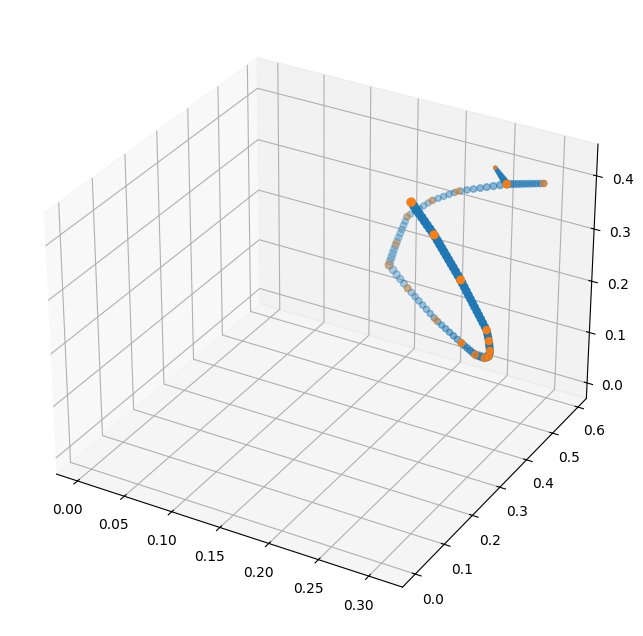

In [10]:
print("t", tree.shape)
points, radii, types = tree[:, :3], tree[:, 3], tree[:, 4:]
print(points.shape)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection="3d")
#ax.scatter(*points.T, s=(220 * radii) ** 2, c=types.argmax(-1), vmin=0, vmax=3)
ax.scatter(*points.T, s=(220 * radii)**2)
#ax.scatter(0, 0, 0, color='red', s=50, label="Origin")
tree2 = final_data[0].reshape(1,-1,4)
points, radii, types = tree2[:, :, :3], tree2[:, :, 3], tree2[:, :, 4:]
ax.scatter(*points.T, s=(220 * radii) ** 2)


[10, 9, 2, 2]
[0.         0.02935669 0.02317998 0.02141981 0.02189755 0.02273727
 0.01959114 0.07890544 0.07240973 0.05352879]
[0.         0.04842277 0.05600046 0.03804901 0.03985964 0.05051708
 0.04136546 0.03575879 0.05529032]
[0.        0.0665598]
[0.         0.03854766]
torch.Size([1, 128, 3])


/tmp/ipykernel_3020943/4012633921.py:18: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1724789115564/work/aten/src/ATen/native/TensorShape.cpp:3697.)
  ax.scatter(*points.T, s=(22000 * radii) ** 2, c=types.argmax(-1), vmin=0, vmax=3)


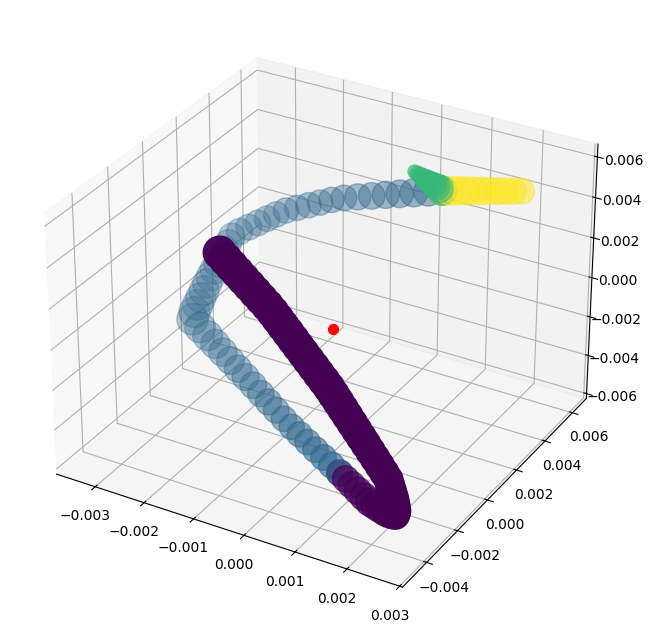

[5, 5, 6, 6]
[0.         0.01905902 0.03346078 0.05949077 0.12446893]
[0.         0.01598435 0.01294938 0.01255847 0.08208652]
[0.         0.06368728 0.08701906 0.03049067 0.02513809 0.02602584]
[0.         0.06583451 0.02567825 0.11639529 0.02896364 0.03176757]
torch.Size([1, 128, 3])


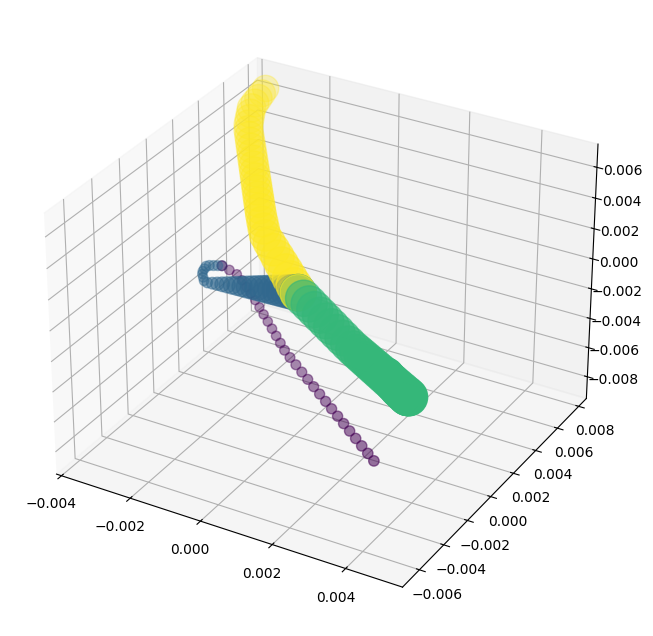

[10, 7, 4, 4]
[0.         0.02777879 0.01415168 0.01686932 0.01967907 0.01499711
 0.014997   0.01735824 0.01694821 0.03777164]
[0.         0.03973349 0.03344212 0.03713911 0.03559599 0.02777032
 0.02634966]
[0.         0.02503426 0.02395718 0.02754947]
[0.         0.02919363 0.02215662 0.02091614]
torch.Size([1, 128, 3])


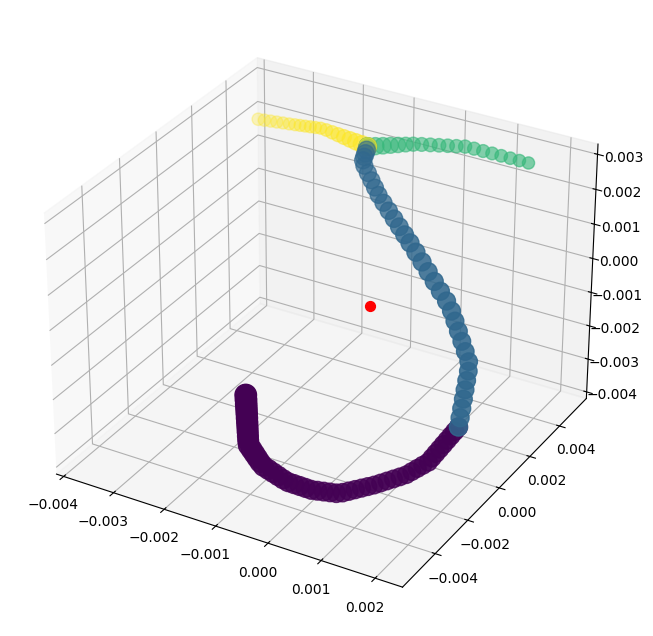

[10, 5, 6, 6]
[0.         0.02914544 0.03500617 0.07681829 0.0549601  0.02433864
 0.05345306 0.05980272 0.04589171 0.0307052 ]
[0.         0.06378362 0.02528226 0.02464102 0.0433116 ]
[0.         0.04940197 0.01948469 0.03406582 0.03827516 0.11425919]
[0.         0.04879783 0.02805356 0.03568351 0.04524092 0.05495311]
torch.Size([1, 128, 3])


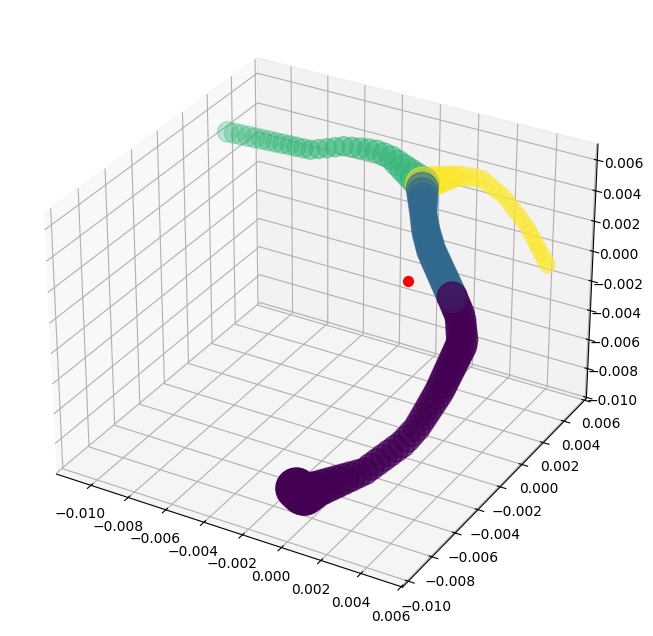

[6, 3, 8, 8]
[0.         0.02185211 0.03138636 0.02631679 0.01698953 0.04088898]
[0.         0.01142584 0.05192924]
[0.         0.02828998 0.01856819 0.01871399 0.01886417 0.02032144
 0.02300699 0.02877208]
[0.         0.02883026 0.04345838 0.06324681 0.03237872 0.03371555
 0.01393725 0.02444189]
torch.Size([1, 128, 3])


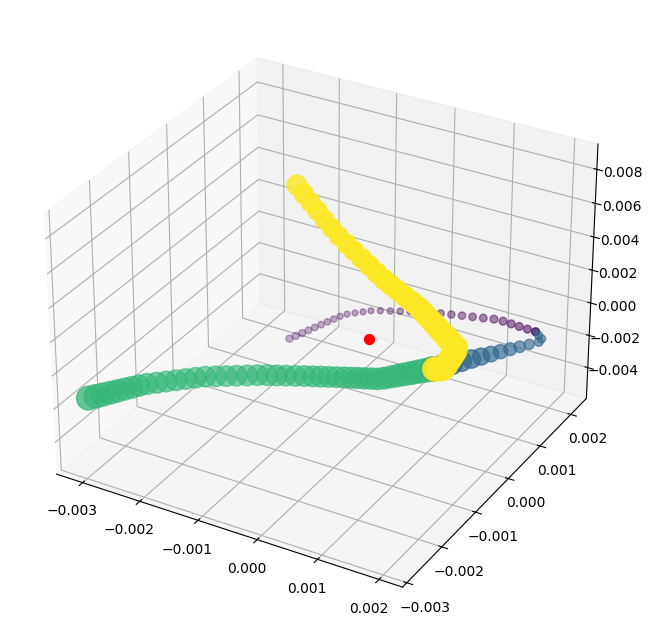

[5, 2, 3, 7]
[0.         0.03427507 0.04082362 0.03307518 0.03043034]
[0.         0.06087133]
[0.         0.04301659 0.02806319]
[0.         0.04819179 0.02301054 0.01845746 0.04151917 0.03892072
 0.04029468]
torch.Size([1, 128, 3])


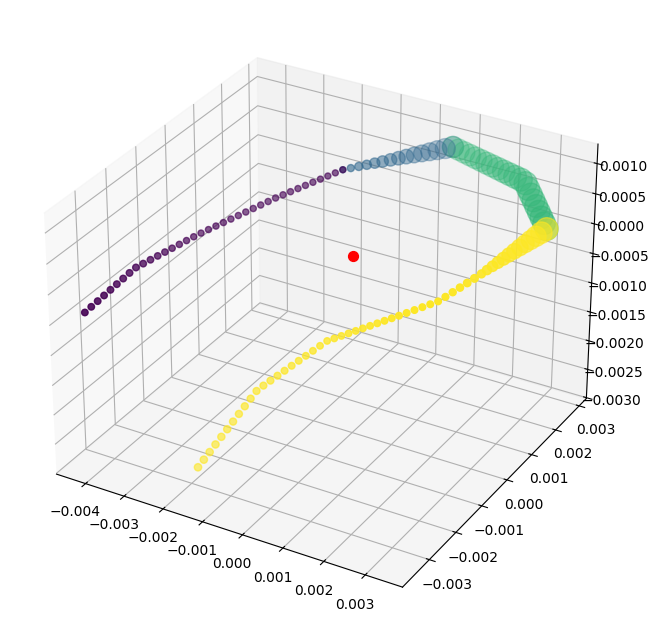

In [11]:
train_set = AneuriskVesselSet(split="train", path="aneurisk")

train_loader = torch.utils.data.DataLoader(
    dataset=train_set,
    batch_size=1,
    num_workers=0,
    drop_last=True,
    shuffle=False,
)

for i, (inputs, labels) in enumerate(train_loader):
    

    points, radii, types = inputs[:, :, :3], inputs[:, :, 3], inputs[:, :, 4:]
    print(points.shape)
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(projection="3d")
    ax.scatter(*points.T, s=(22000 * radii) ** 2, c=types.argmax(-1), vmin=0, vmax=3)
    #ax.scatter(*points.T, s=(10000 * radii) ** 2, c=types.argmax(-1), vmin=0, vmax=3)
    ax.scatter(0, 0, 0, color='red', s=50, label="Origin")
    
    #ax.set_xlim(-1, 1)
    #ax.set_ylim(-1, 1)
    #ax.set_zlim(-1, 1)

    plt.show()
    if i > 4:
        break

keep trees with a maximum of 4 branches and depth 10. for this I need to find the optimal root of the tree. the problem is the segments in the structure generated are not contiguous so if I choose the first four I end up with separated segments and not a vessel structure

In [12]:
a = np.load("centerlineArray/centerlines1.npy")